# Laboratorio 4: Mejorando el Análisis de Sentimientos con LSTM y Características Adicionales

Objetivo: Incrementar la precisión en el análisis de sentimientos sobre las críticas de películas utilizando RNNs con unidades LSTM y la incorporación de características (features) adicionales.

**Instrucciones:**
1. Importación de Datos: Utilice el conjunto de datos IMDB proporcionado por Keras. pero esta vez, en lugar de utilizar sólo las 20.000 palabras más frecuentes, utilice las 50.000 palabras más frecuentes.
2. Pre-procesamiento: <br>
    • Secuencie y rellene las críticas para que todas tengan una longitud uniforme. <br>
    • De las críticas, extraiga características (features) adicionales, por ejemplo. la longitud de la crítica, la proporción de palabras positivas/negativas y cualquier otra que considere pueda ser útil.
3. Modelo: <br>
    •Cree un modelo LSTM que acepte las características (features) adicionales junto con la secuencia de palabras. <br>
    •Intente usar una arquitectura más compleja, incorporando más capas LSTM, capas de Dropout para la regularización y tal vez alguna capa densamente conectada después de la LSTM.  (ver también la referencia al final de este documento)<br>
4. Entrenamiento y Evaluación: Entrene su modelo con el conjunto de datos de entrenamiento y evalúe su desempeño con el conjunto de datos de prueba.
5. Informe: Escriba un breve informe que describa:<br>
    •Las características adicionales seleccionadas y la razón de su elección.<br>
    •La arquitectura del modelo y las razones detrás de sus elecciones.<br>
    •Los resultados obtenidos y una breve comparación con el modelo simple del ejercicio anterior.<br>


## Rúbrica de Evaluación:
1. Importación y Pre-procesamiento (30 puntos) <br>
•Correcta importación del conjunto de datos con 50,000 palabras más frecuentes: 10 puntos. <br>
•Secuenciación y relleno de las críticas: 10 puntos. <br>
•Extracción y adecuada justificación de características adicionales: 10 puntos. <br>
2. Arquitectura del Modelo (30 puntos) <br>
•Adecuado diseño de la arquitectura LSTM: 10 puntos. <br>
•Incorporación efectiva de características adicionales en el modelo: 10 puntos. <br>
•Uso de técnicas adicionales (e.g., Dropout, capas densamente conectadas): 10 puntos. <br>
3. Entrenamiento y Evaluación (20 puntos) <br>
•Correcto entrenamiento del modelo sin errores: 10 puntos. <br>
•Evaluación y comparación adecuada con el modelo del ejercicio anterior: 10 puntos. <br>
4. Informe (20 puntos) <br>
•Clara descripción de características adicionales y su relevancia: 5 puntos. <br>
•Explicación coherente de la arquitectura del modelo: 5 puntos. <br>
•Presentación de resultados y comparativa efectiva: 10 puntos. <br>

Recurso de Datos:
[IMDB Movie reviews sentiment classification](https://keras.io/api/datasets/)

Referencia:
https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf


In [2]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Model
import numpy as np

In [3]:
# Importar el conjunto de datos IMDB con las 50,000 palabras más frecuentes
max_features = 50000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Imprimir la cantidad de datos de entrenamiento y prueba
print(f"Datos de entrenamiento: {len(x_train)}")
print(f"Datos de prueba: {len(x_test)}")

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Datos de entrenamiento: 25000
Datos de prueba: 25000


In [11]:
from keras.preprocessing.sequence import pad_sequences

# Definir la longitud máxima de las secuencias
maxlen = 500

# Aplicar pad_sequences a los datos de entrenamiento y prueba
x_train_padded = pad_sequences(x_train, maxlen=maxlen)
x_test_padded = pad_sequences(x_test, maxlen=maxlen)

# Definir diccionarios de palabras positivas y negativas
positive_words = set(['good', 'great', 'excellent', 'amazing', 'wonderful', 'best', 'love', 'like'])
negative_words = set(['bad', 'terrible', 'awful', 'worst', 'hate', 'dislike'])

# Función para calcular la longitud de la crítica
def review_length(review):
    return len(review)

# Función para calcular la proporción de palabras positivas
def positive_word_proportion(review):
    return sum(1 for word in review if word in positive_words) / len(review)

# Función para calcular la proporción de palabras negativas
def negative_word_proportion(review):
    return sum(1 for word in review if word in negative_words) / len(review)

# Aplicar las funciones a los datos de entrenamiento y prueba
x_train_lengths = np.array([review_length(review) for review in x_train])
x_train_positive_proportions = np.array([positive_word_proportion(review) for review in x_train])
x_train_negative_proportions = np.array([negative_word_proportion(review) for review in x_train])

x_test_lengths = np.array([review_length(review) for review in x_test])
x_test_positive_proportions = np.array([positive_word_proportion(review) for review in x_test])
x_test_negative_proportions = np.array([negative_word_proportion(review) for review in x_test])

# Combinar las características adicionales con las secuencias de palabras
x_train_additional_features = np.stack((x_train_lengths, x_train_positive_proportions, x_train_negative_proportions), axis=-1)
x_test_additional_features = np.stack((x_test_lengths, x_test_positive_proportions, x_test_negative_proportions), axis=-1)

# Concatenar las secuencias de palabras con las características adicionales
x_train = np.concatenate([x_train_padded, x_train_additional_features], axis=1)
x_test = np.concatenate([x_test_padded, x_test_additional_features], axis=1)

# Imprimir las dimensiones de los datos preprocesados
print(f"Dimensiones de x_train: {x_train.shape}")
print(f"Dimensiones de x_test: {x_test.shape}")

Dimensiones de x_train: (25000, 503)
Dimensiones de x_test: (25000, 503)


In [5]:
# Definir el modelo secuencial
model = Sequential()

# Añadir una capa de embedding
model.add(Embedding(input_dim=50000, output_dim=128, input_length=maxlen))

# Añadir una capa LSTM
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))

# Añadir una capa densa con activación sigmoide
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Imprimir el resumen del modelo
model.summary()

c:\Users\aleaz\anaconda3\envs\recentPytorchWithCuda\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Definir el número de épocas y el tamaño del batch
epochs = 10
batch_size = 32

# Entrenar el modelo
history = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_test, y_test))

# Evaluar el modelo en los datos de prueba
score = model.evaluate(x_test, y_test, batch_size=batch_size)
print(f"Loss en el conjunto de prueba: {score[0]}")
print(f"Accuracy en el conjunto de prueba: {score[1]}")

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 227s 288ms/step - accuracy: 0.7078 - loss: 0.5522 - val_accuracy: 0.8010 - val_loss: 0.4350
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 221s 283ms/step - accuracy: 0.8542 - loss: 0.3594 - val_accuracy: 0.8432 - val_loss: 0.3726
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 217s 278ms/step - accuracy: 0.8930 - loss: 0.2675 - val_accuracy: 0.8488 - val_loss: 0.3776
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 219s 280ms/step - accuracy: 0.9430 - loss: 0.1616 - val_accuracy: 0.8411 - val_loss: 0.4616
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 218s 279ms/step - accuracy: 0.9603 - loss: 0.1127 - val_accuracy: 0.8299 - val_loss: 0.4470
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 216s 276ms/step - accuracy: 0.9708 - loss: 0.0833 - val_accuracy: 0.8540 - val_loss: 0.5450
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 219s 280ms/step - accuracy: 0.9849 - loss: 0.0504 - val_accuracy: 0.8325 - val_loss: 0.5586
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 217s 277ms/step - accuracy: 0.9850 -

In [8]:
# accuracy y loss del modelo 2 decimales. 
print(f"Accuracy: {score[1]:.2f}")
print(f"Loss: {score[0]:.2f}")

Accuracy: 0.84
Loss: 0.75


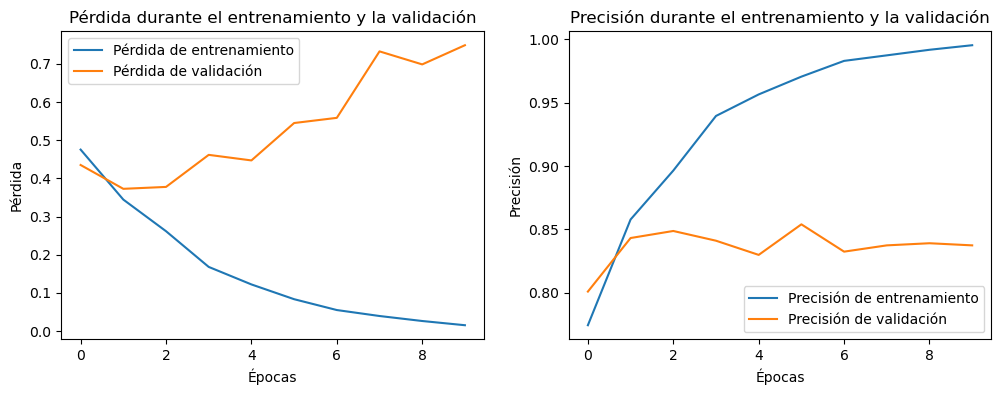

In [7]:
import matplotlib.pyplot as plt

# Graficar la pérdida del entrenamiento y la validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Graficar la precisión del entrenamiento y la validación
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [9]:
# Definir el nombre del archivo donde se guardará el modelo
model_filename = 'modelo_entrenado.h5'

# Guardar el modelo
model.save(model_filename)

print(f"Modelo guardado en {model_filename}")

Modelo guardado en modelo_entrenado.h5
